# LangChain: Models, Prompts and Output Parsers


## Outline

 * Direct API calls to OpenAI
 * API calls through LangChain:
   * Prompts
   * Models
   * Output parsers

## Get your [OpenAI API Key](https://platform.openai.com/account/api-keys)

In [ ]:
#!pip install python-dotenv
#!pip install openai

In [ ]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

## Chat API : OpenAI

Let's start with a direct API calls to OpenAI.

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    return response.choices[0].message["content"]


In [ ]:
get_completion("What is 1+1?")

In [ ]:
customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse,\
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

In [ ]:
style = """American English \
in a calm and respectful tone
"""

In [ ]:
prompt = f"""Translate the text \
that is delimited by triple backticks 
into a style that is {style}.
text: ```{customer_email}```
"""

print(prompt)

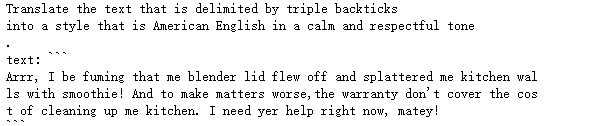

In [ ]:
response = get_completion(prompt)

In [ ]:
response

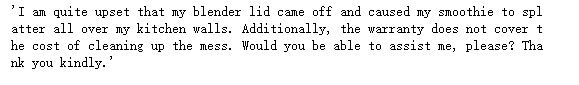

## Chat API : LangChain

Let's try how we can do the same using LangChain.

In [ ]:
#!pip install --upgrade langchain

### Model

In [ ]:
from langchain.chat_models import ChatOpenAI

In [ ]:
# To control the randomness and creativity of the generated
# text by an LLM, use temperature = 0.0
chat = ChatOpenAI(temperature=0.0)
chat

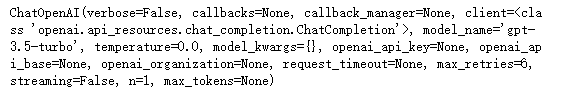

### Prompt template

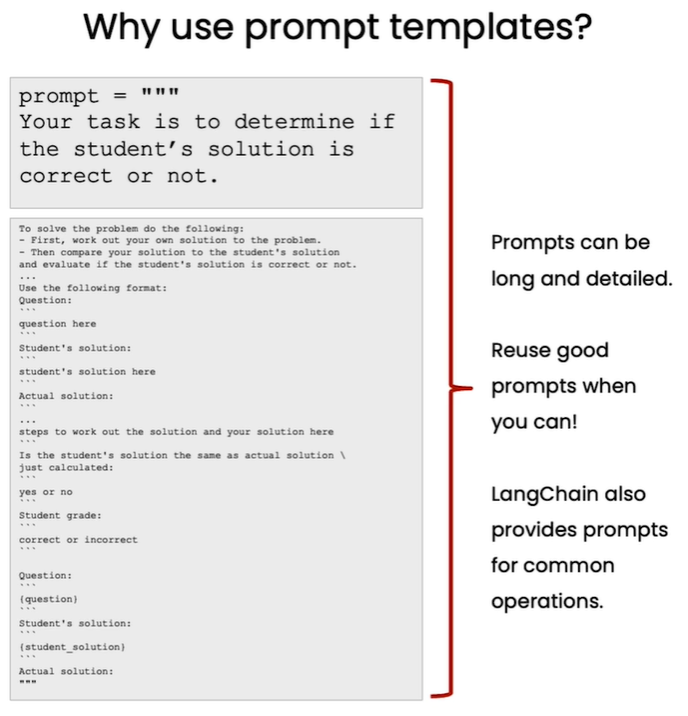

In [ ]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

In [ ]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(template_string)


In [ ]:
prompt_template.messages[0].prompt

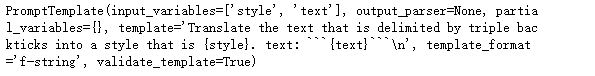

In [ ]:
prompt_template.messages[0].prompt.input_variables

In [ ]:
customer_style = """American English \
in a calm and respectful tone
"""

In [ ]:
customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, \
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

In [ ]:
customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

In [ ]:
print(type(customer_messages))
print(type(customer_messages[0]))

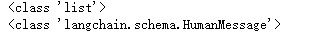

In [ ]:
print(customer_messages)

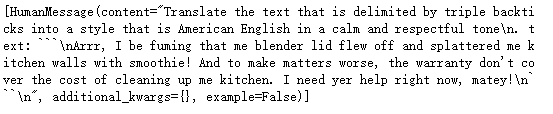

In [ ]:
print(customer_messages[0])

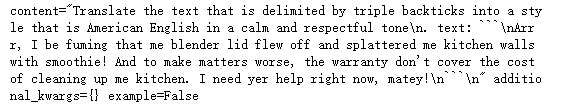

In [ ]:
# Call the LLM to translate to the style of the customer message
customer_response = chat(customer_messages)

In [ ]:
print(customer_response.content)

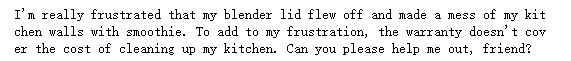

In [ ]:
service_reply = """Hey there customer, \
the warranty does not cover \
cleaning expenses for your kitchen \
because it's your fault that \
you misused your blender \
by forgetting to put the lid on before \
starting the blender. \
Tough luck! See ya!
"""

In [ ]:
service_style_pirate = """\
a polite tone \
that speaks in English Pirate\
"""

In [ ]:
service_messages = prompt_template.format_messages(
    style=service_style_pirate,
    text=service_reply)

print(service_messages[0].content)

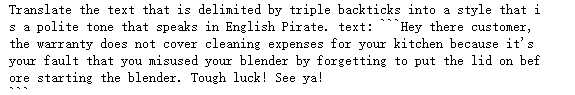

In [ ]:
service_response = chat(service_messages)
print(service_response.content)

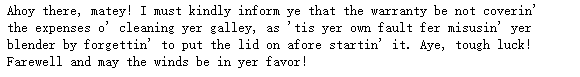

## Output Parsers
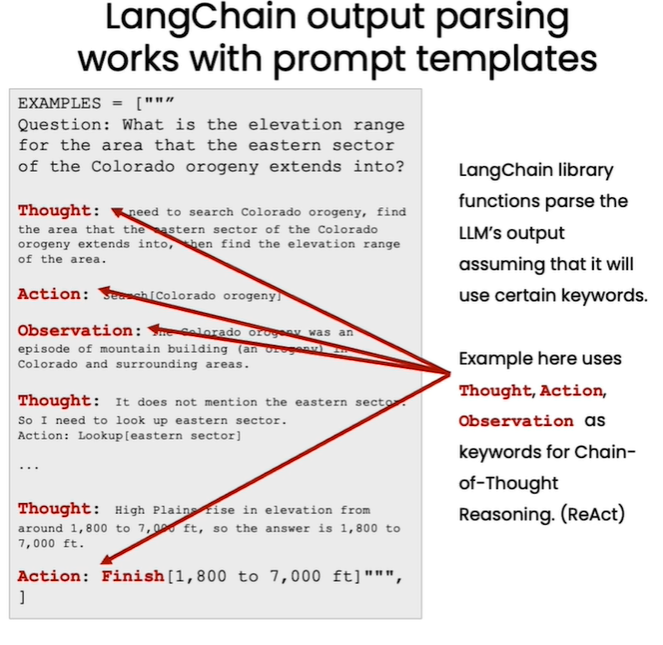  

<br>
Let's start with defining how we would like the LLM output to look like:

In [ ]:
{
  "gift": False,
  "delivery_days": 5,
  "price_value": "pretty affordable!"
}

In [ ]:
customer_review = """\
This leaf blower is pretty amazing.  It has four settings:\
candle blower, gentle breeze, windy city, and tornado. \
It arrived in two days, just in time for my wife's \
anniversary present. \
I think my wife liked it so much she was speechless. \
So far I've been the only one using it, and I've been \
using it every other morning to clear the leaves on our lawn. \
It's slightly more expensive than the other leaf blowers \
out there, but I think it's worth it for the extra features.
"""

review_template = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product \
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

In [ ]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(review_template)
print(prompt_template)

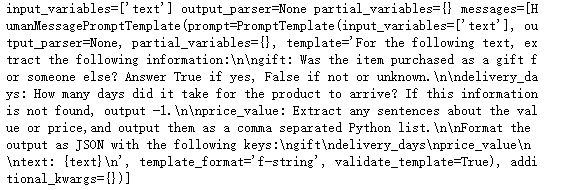

In [ ]:
messages = prompt_template.format_messages(text=customer_review)
chat = ChatOpenAI(temperature=0.0)
response = chat(messages)
print(response.content)


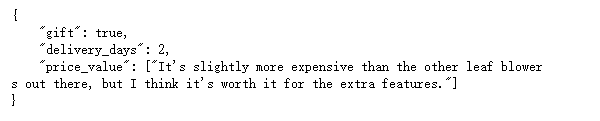

In [ ]:
type(response.content)

In [ ]:
# You will get an error by running this line of code 
# because'gift' is not a dictionary
# 'gift' is a string
response.content.get('gift')

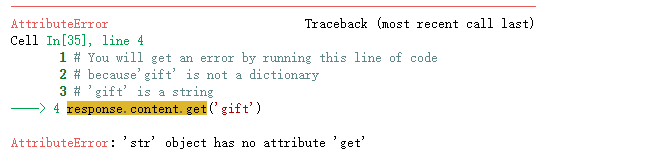

### Parse the LLM output string into a Python dictionary

In [ ]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [ ]:
gift_schema = ResponseSchema(name="gift",
                             description="Was the item purchased\
                             as a gift for someone else? \
                             Answer True if yes,\
                             False if not or unknown.")
delivery_days_schema = ResponseSchema(name="delivery_days",
                                      description="How many days\
                                      did it take for the product\
                                      to arrive? If this \
                                      information is not found,\
                                      output -1.")
price_value_schema = ResponseSchema(name="price_value",
                                    description="Extract any\
                                    sentences about the value or \
                                    price, and output them as a \
                                    comma separated Python list.")

response_schemas = [gift_schema, 
                    delivery_days_schema,
                    price_value_schema]

In [ ]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [ ]:
format_instructions = output_parser.get_format_instructions()


In [ ]:
print(format_instructions)

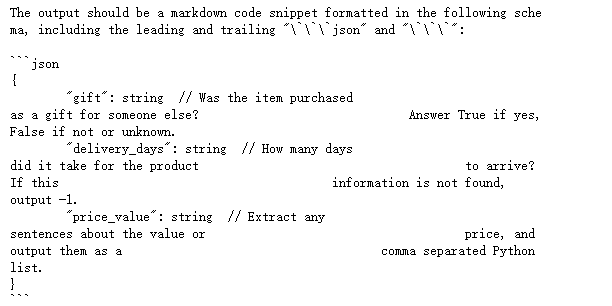

In [ ]:
review_template_2 = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product\
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

text: {text}

{format_instructions}
"""

prompt = ChatPromptTemplate.from_template(template=review_template_2)

messages = prompt.format_messages(text=customer_review, 
                                format_instructions=format_instructions)

In [ ]:
print(messages[0].content)

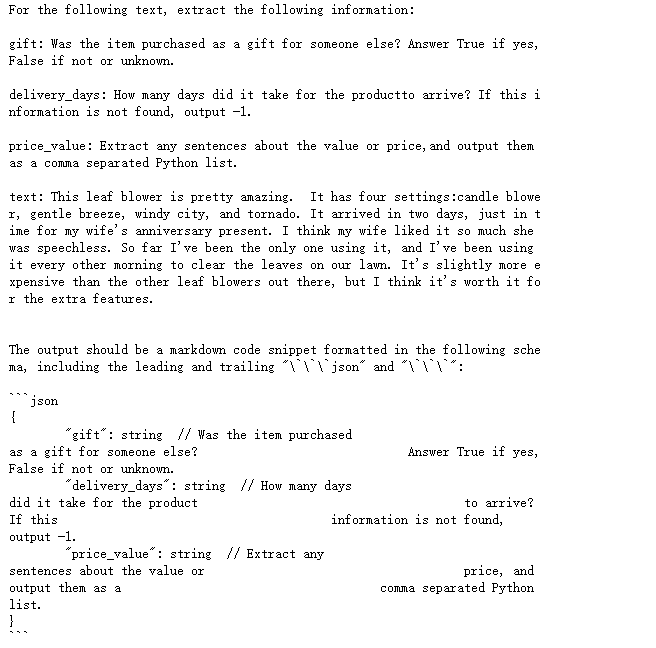

In [ ]:
response = chat(messages)

In [ ]:
print(response.content)

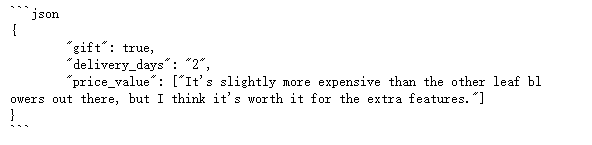

In [ ]:
output_dict = output_parser.parse(response.content)

In [ ]:
output_dict

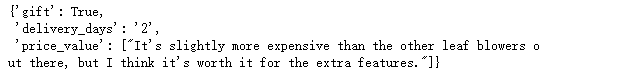

In [ ]:
type(output_dict)

In [ ]:
output_dict.get('delivery_days')